In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
# Get data to work with

from observatorio_laboral.offer.offer_controller import OfferController
from observatorio_laboral.offer.date_range import DateRange

text_fields = []
oc = OfferController(text_fields = ["Job Title", "Description", "Qualifications"])
date_range = DateRange(1, 2013, 5, 2017)
source = "symplicity"

oc.load_offers(source, date_range)
print(len(oc.offers))

oc.filter_offers_by_career("ECONOMÍA")
print(len(oc.offers))

oc.filter_offers_by_field("Areas")
print(len(oc.offers))

offer_texts = oc.get_text()
offer_classes = oc.get_field_labels("Areas")

80706
12653
553


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vec = TfidfVectorizer(offer_texts, ngram_range=(1,1), stop_words = stopwords.words('spanish'))
X = offer_texts

Xtr = vec.fit_transform(X)
features = vec.get_feature_names()

In [36]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0    
    #tfidf_means = np.sum(D, axis=0)
    tfidf_means = np.mean(D, axis=0)
    #tfidf_means = np.ma.masked_equal(D, 0).mean(axis=1)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)          
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df        
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [37]:
top_feats_in_doc(Xtr, features, 1, 10)

,feature,tfidf
0,investigación,0.454747
1,prácticantes,0.192630
2,papers,0.192630
3,mining,0.192630
4,estatales,0.192630
5,textos,0.192630
6,revistas,0.180838
7,consultorias,0.180838
8,socioeconómicas,0.180838
9,proyectos,0.173548


In [40]:
y = np.array([",".join(labels) for labels in offer_classes])
dfs = top_feats_by_class(Xtr, y, features, top_n=30)

In [41]:
dfs['PP,TE']

,feature,tfidf
0,argumentación,0.307559
1,capacidad,0.296232
2,canalización,0.288733
3,ortografía,0.275375
4,macroeconómicos,0.265015
5,interpersonales,0.256549
6,apoyo,0.238058
7,macroeconomía,0.232831
8,respuesta,0.217209
9,buena,0.198382


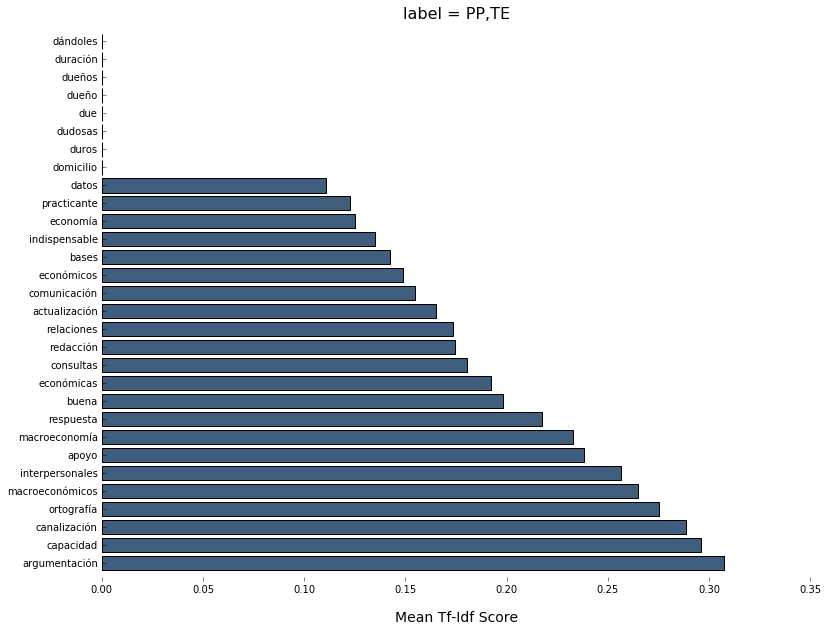

In [43]:
plot_tfidf_classfeats_h([dfs['PP,TE']])

In [13]:
ids_by_label = {}
labels = np.unique(y) 
for label in labels:
    ids = np.where(y==label)
    ids_by_label[label] = ids

In [16]:
ids_by_label

{'EI': (array([5]),),
 'EI,F': (array([ 38, 448]),),
 'EI,F,P': (array([369]),),
 'EI,MC': (array([249]),),
 'EI,TE,OI,MC': (array([227]),),
 'EM': (array([ 26,  28,  48,  53,  76,  81,  83, 143, 169, 172, 196, 203, 255,
         262, 265, 289, 290, 297, 299, 319, 341, 377, 393, 407, 460, 484]),),
 'F': (array([  8,  12,  15,  16,  18,  23,  24,  25,  33,  35,  36,  37,  39,
          41,  43,  44,  46,  49,  54,  55,  57,  58,  60,  65,  66,  68,
          69,  72,  73,  75,  79,  80,  82,  84,  85,  86,  87,  88,  90,
          91,  93,  96,  97,  98, 108, 124, 136, 138, 146, 184, 186, 187,
         216, 236, 242, 261, 268, 270, 278, 284, 296, 301, 318, 327, 329,
         349, 365, 380, 388, 397, 400, 410, 419, 423, 424, 430, 436, 437,
         439, 451, 455, 458, 459]),),
 'F,EM': (array([ 32,  50,  52,  67, 102, 103, 131, 134, 137, 156, 159, 162, 165,
         176, 190, 197, 232, 241, 244, 246, 277, 295, 304, 332, 339, 344,
         358, 375, 406, 409, 431, 450, 479]),),
 'F,MC': (